In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import nasdaqdatalink
import os
from dotenv import load_dotenv
load_dotenv()
API_KEY= os.getenv('API_KEY')
nasdaqdatalink.ApiConfig.api_key = API_KEY

# Load in Asset Data

In [2]:

# Define the asset universe
tickers = {
    # US Equities
    'SPY': 'QUOTEMEDIA/PRICES',  # S&P 500 ETF
    'QQQ': 'QUOTEMEDIA/PRICES',  # Nasdaq 100 ETF
    'IWM': 'QUOTEMEDIA/PRICES',  # Russell 2000 ETF (Small Cap)
    # International Equities
    'EFA': 'QUOTEMEDIA/PRICES',  # MSCI EAFE ETF (Developed Markets ex-US/Canada)
    'EEM': 'QUOTEMEDIA/PRICES',  # MSCI Emerging Markets ETF
    # Fixed Income
    'AGG': 'QUOTEMEDIA/PRICES',  # US Aggregate Bond ETF
    'TLT': 'QUOTEMEDIA/PRICES',  # US 20+ Year Treasury Bond ETF
    # Commodities
    'GLD': 'QUOTEMEDIA/PRICES',  # Gold ETF
    'USO': 'QUOTEMEDIA/PRICES',  # Oil ETF
    # Real Estate
    'VNQ': 'QUOTEMEDIA/PRICES',   # US Real Estate ETF
    # Adding a couple more for diversity
    'GSG': 'QUOTEMEDIA/PRICES', # Broad Commodities ETF
    'HYG': 'QUOTEMEDIA/PRICES'  # High Yield Corporate Bond ETF
}

start_date = '2010-01-01'


In [3]:
# Fetch data for each ticker
all_data = {}
for ticker, table in tickers.items():
    try:
        # Fetch data from the specified start_date
        data = nasdaqdatalink.get_table(
            table, 
            ticker=ticker, 
            qopts={'columns': ['date', 'adj_close']},
            date={'gte': start_date},
            paginate=True
        )
        if not data.empty:
            data = data.set_index('date')
            all_data[ticker] = data['adj_close']
        else:
            print(f"No data found for {ticker}")
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Combine into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    price_df = price_df.sort_index() # Ensure dates are in ascending order
    print("\nSuccessfully fetched and combined data for all available tickers.")
    print(f"Price data from {price_df.index.min()} to {price_df.index.max()}")
else:
    print("No data was fetched. Please check ticker symbols and API key.")


Successfully fetched and combined data for all available tickers.
Price data from 2010-01-04 00:00:00 to 2025-05-13 00:00:00


In [5]:
# Resample to monthly frequency (end of month) and calculate returns
if 'price_df' in locals() and not price_df.empty:
    # Forward fill to handle missing values before resampling, then backfill
    price_df_filled = price_df.ffill().bfill()
    
    # Resample to monthly frequency, taking the last available price in the month
    monthly_prices = price_df_filled.resample('ME').last()
    
    # Calculate monthly returns
    monthly_returns = monthly_prices.pct_change()
    
    # Drop the first row of NaNs resulting from pct_change()
    monthly_returns = monthly_returns.dropna(how='all', axis=0)

else:
    print("price_df is not available or empty. Cannot calculate monthly returns.")

In [6]:
# Standardize the monthly returns by their volatility
if 'monthly_returns' in locals() and not monthly_returns.empty:
    # Calculate the standard deviation for each asset's monthly returns
    returns_std = monthly_returns.std()
    
    # Standardize the returns
    # Avoid dividing by zero if any asset has zero standard deviation (e.g., if all returns are the same or NaN)
    standardized_monthly_returns = monthly_returns.copy()
    for col in standardized_monthly_returns.columns:
        if returns_std[col] != 0:
            standardized_monthly_returns[col] = standardized_monthly_returns[col] / returns_std[col]
        else:
            print(f"Warning: Standard deviation for {col} is 0. Standardized returns for this asset will be set to 0 or NaN depending on original values.")
            if monthly_returns[col].notna().all() and (monthly_returns[col] == 0).all():
                 standardized_monthly_returns[col] = 0 # All returns were 0
            else:
                 standardized_monthly_returns[col] = np.nan # Or handle as appropriate for other zero std cases
else:
    print("monthly_returns DataFrame is not available or empty. Cannot standardize returns.")

<Axes: xlabel='date'>

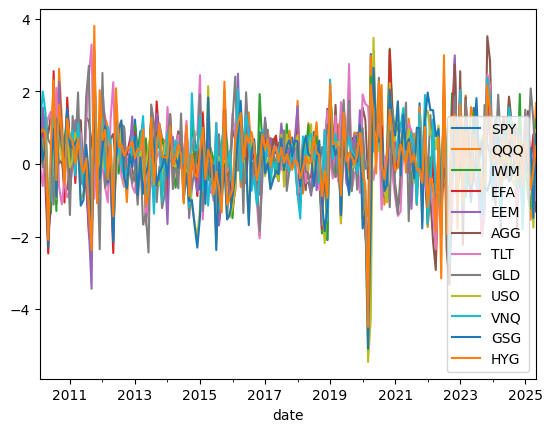

In [7]:
standardized_monthly_returns.plot()

# Load in Macro Data

In [8]:
FILE1             = "../data/Assignment_2_data.xlsm"

fed = pd.read_excel(FILE1, sheet_name='FF', index_col='Date')
fed.rename(columns={'Rate': 'PX_Last'}, inplace=True)
fed = fed[~fed.index.duplicated(keep='last')]

fed = (fed            # daily EFFR
           .resample('ME').mean()      # calendar‑month mean
           .asfreq('B', method='ffill')  # fill forward to biz days
           [fed.index.min():])   # trim to asset window
# select only >2010
fed = fed[fed.index >= '2010-01-01']

<Axes: xlabel='Date'>

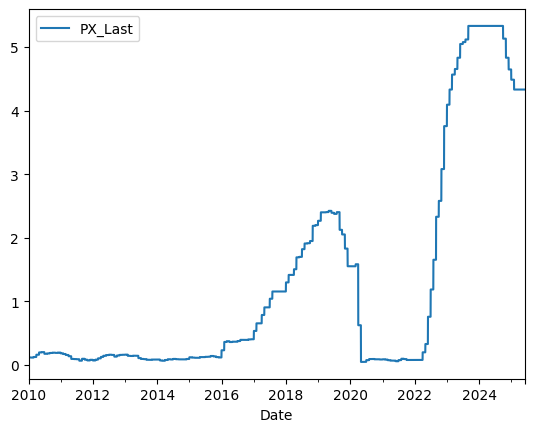

In [9]:
fed.plot()

In [24]:
ism = pd.read_excel(FILE1, sheet_name='ISM', index_col='Date')
ism = ism[~ism.index.duplicated(keep='last')]
ism = ism[ism.index >= '2010-01-01']
ism


,ISM
Date,
2010-01-31,56.3
2010-02-28,55.5
2010-03-31,58.8
2010-04-30,58.1
2010-05-31,57.4
...,...
2024-12-31,49.2
2025-01-31,50.9
2025-02-28,50.3


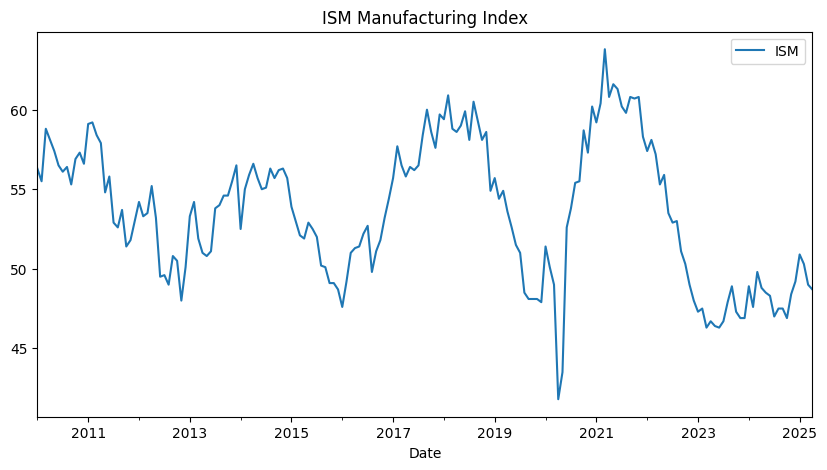

In [28]:
ism.plot(figsize = (10, 5))
plt.title("ISM Manufacturing Index")
plt.show()

In [22]:
nfp = pd.read_csv("../data/nonfarm_payrolls.csv", index_col = "observation_date")
nfp.index = pd.to_datetime(nfp.index)
nfp.rename(columns = {"PAYEMS": "nfp"}, inplace = True)
nfp.index.name = "Date"
nfp

,nfp
Date,
2010-01-01,129802
2010-02-01,129705
2010-03-01,129865
2010-04-01,130120
2010-05-01,130643
...,...
2024-12-01,158942
2025-01-01,159053
2025-02-01,159155


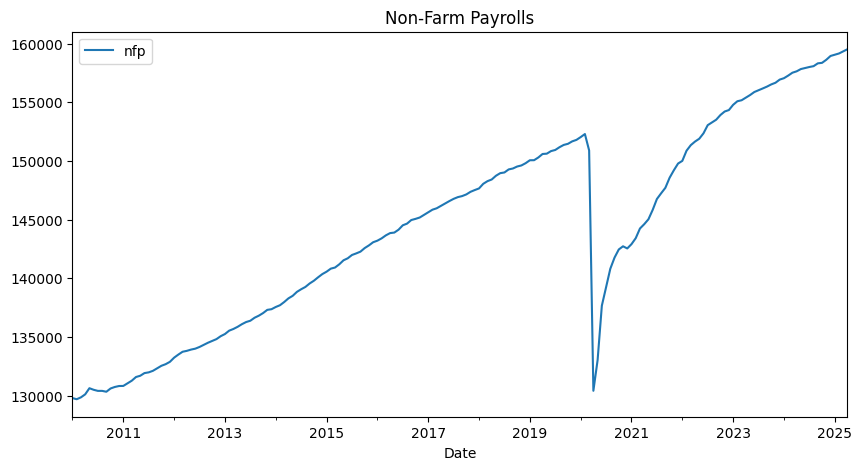

In [29]:
nfp.plot(figsize = (10, 5))
plt.title("Non-Farm Payrolls")
plt.show()

In [32]:
pce = pd.read_csv("../data/core_pce.csv", index_col = "observation_date")
pce.index = pd.to_datetime(pce.index)
pce.rename(columns = {"PCEPILFE": "pce"}, inplace = True)
pce.index.name = "Date"
pce

,pce
Date,
2008-11-01,87.952
2008-12-01,87.909
2009-01-01,87.882
2009-02-01,87.952
2009-03-01,88.015
...,...
2024-11-01,123.716
2024-12-01,123.980
2025-01-01,124.398


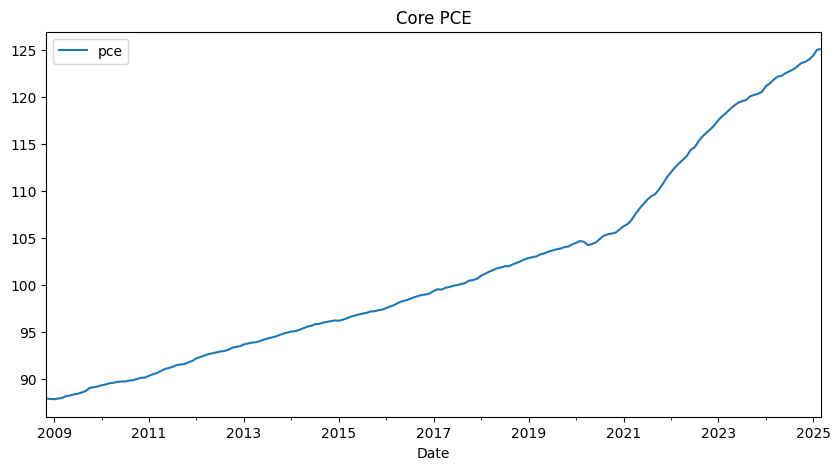

In [33]:
pce.plot(figsize = (10, 5))
plt.title("Core PCE")
plt.show()